Import libraries

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

We already have images on google drive so we need to mount Google drive here

In [117]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
root_path = '/content/gdrive/My Drive/Colab Notebooks/Datasets/dogs'

I copied this method for splitting the available source data into training and testing sets

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

Let's run this method on the dog data

split_size = 0.9 means that 90% of the available images will go into the training set and 10% of them will go into the testing set

Do not rerun this without deleting the training/testing folders. It would just split the source data again and give loads of duplicates and just be generally terrible

In [ ]:
GSD_SOURCE_DIR = root_path + "/german_shepherd/"
GSD_TRAINING_DIR = root_path + "/training/gsd/"
GSD_TEST_DIR = root_path + "/testing/gsd/"
GOLDEN_SOURCE_DIR = root_path + "/golden_retriever/"
GOLDEN_TRAINING_DIR = root_path + "/training/golden/"
GOLDEN_TEST_DIR = root_path + "/testing/golden/"

split_size = .9

split_data(GSD_SOURCE_DIR, GSD_TRAINING_DIR, GSD_TEST_DIR, split_size)
split_data(GOLDEN_SOURCE_DIR, GOLDEN_TRAINING_DIR, GOLDEN_TEST_DIR, split_size)

Let's check some lengths of stuff

In [ ]:
print("Number of gsd training images: " + str(len(os.listdir(GSD_TRAINING_DIR))))
print("Number of gsd testing images: " + str(len(os.listdir(GSD_TEST_DIR))))

print("Number of golden training images: " + str(len(os.listdir(GOLDEN_TRAINING_DIR))))
print("Number of golden testing images: " + str(len(os.listdir(GOLDEN_TEST_DIR))))

Number of gsd training images: 116
Number of gsd testing images: 13
Number of golden training images: 116
Number of golden testing images: 13


There are not very many images, we might be overfitting later but this is only a proof-of-concept really ⚡

Define the model - this is copied from Google's cats vs dogs classification example exercise but I had to change the learning rate to slow down the learning in order to get better results

I presume that you can change the input_shape but when I tried it, I got errors and I did not spend a lot more time on it

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])


batch_size is important here - too small and training can have better outcomes but can easily overfit. 

I am using batch_size = 32, which is the default value even if I had not defined it

I took the train_datagen from another tutorial, which uses rescaling, rotation, zooming, flipping in order to improve upon the very little data that I have

In [ ]:

TRAINING_DIR = root_path + "/training/"
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.5,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(250, 250))

VALIDATION_DIR = root_path + "/testing/"

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='binary',
                                                              target_size=(250, 250))

Found 232 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


Observationally, training outcome can vary a bit between runs but I found that 12 epochs gave the best answer that I could get

In [ ]:
history = model.fit(train_generator, epochs=12, steps_per_epoch=7,
                    validation_data=validation_generator, validation_steps=1)

Epoch 1/12
7/7 [==============================] - 20s 3s/step - loss: 1.8854 - acc: 0.5850 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/12
7/7 [==============================] - 18s 3s/step - loss: 0.6927 - acc: 0.5450 - val_loss: 0.6950 - val_acc: 0.5000
Epoch 3/12
7/7 [==============================] - 18s 3s/step - loss: 0.6943 - acc: 0.5450 - val_loss: 0.6826 - val_acc: 0.7692
Epoch 4/12
7/7 [==============================] - 19s 3s/step - loss: 0.6816 - acc: 0.5402 - val_loss: 0.6828 - val_acc: 0.5000
Epoch 5/12
7/7 [==============================] - 19s 3s/step - loss: 0.6725 - acc: 0.5938 - val_loss: 0.6541 - val_acc: 0.6538
Epoch 6/12
7/7 [==============================] - 18s 2s/step - loss: 0.6590 - acc: 0.5950 - val_loss: 0.6338 - val_acc: 0.6154
Epoch 7/12
7/7 [==============================] - 18s 2s/step - loss: 0.5992 - acc: 0.7050 - val_loss: 0.7166 - val_acc: 0.6154
Epoch 8/12
7/7 [==============================] - 20s 3s/step - loss: 0.6164 - acc: 0.6964 - val_loss: 0

I am saving the model to my Google Drive. H5 format makes the model into a single file, which is an older format for Tensorflow but it means fewer files for me to transfer between machines to convert to Tensorflow JS later

In [ ]:
model.save("/content/gdrive/My Drive/Colab Notebooks/Models/dogs_trained_tf_model.h5", save_format='h5')

I took these plots straight from the Google tutorial. 

Fast.AI has better plots

<Figure size 432x288 with 0 Axes>

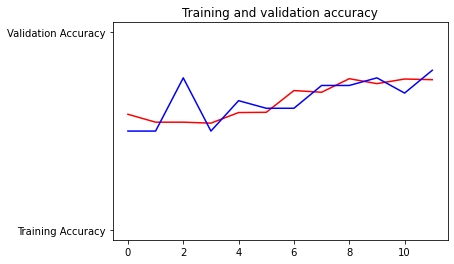

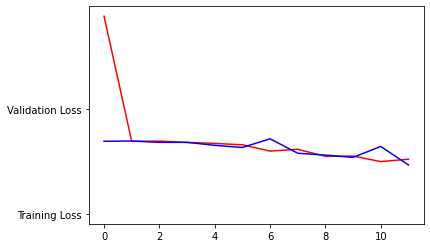

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


Let's just check this model now with some images it has not seen before

In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/Models/dogs_trained_tf_model.h5")

In [ ]:
def which_dog_is_it(image_path):
  img=image.load_img(image_path, target_size=(250, 250))
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])

  if classes[0]>0:
      print("This dog is a gsd!")
      
  else:
      print("This dog is a golden retriever!")

In [ ]:
path_gsd_real = root_path + "/real-world/gsd/gsd.jpg"
which_dog_is_it(path_gsd_real)

path_gsd_real_1 = root_path + "/real-world/gsd/gsd-1.jpg"
which_dog_is_it(path_gsd_real_1)

path_golden_real = root_path + "/real-world/golden/golden.jpg"
which_dog_is_it(path_golden_real)

path_golden_real_1 = root_path + "/real-world/golden/retriever-1.jpg"
which_dog_is_it(path_golden_real_1)

[1.]
This dog is a gsd!
[8.3213395e-24]
This dog is a gsd!
[0.]
This dog is a golden retriever!
[0.]
This dog is a golden retriever!


Seems to work. Obviously this is not an industrial problem or we would be testing and training on a lot more images 😆